# Praktikum 1 - RNN untuk Analisis Sentimen

## Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
import numpy as np 
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar() 

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, 
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1): # take(1) mengambil 1 data
  print('text: ', example.numpy()) # mengambil data text
  print('label: ', label.numpy()) # mengambil data label

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I don\'t understand how "2 of us" receive such a high rating... I thought that the first half dragged on and the second half didnt make sense, followed by an unresolved climax which was not worth the trouble. However, I did like Jared Harris\' performance of John Lennon which was worth the wasted 2 hours.'
 b'I gave this film 2 stars only because Dominic Monaghan actually put effort through in his acting. Everything else about this film is extremely amateur. Everything associated with the direction of this film was very poorly executed. Not only should the director rethink what she is doing for a life career but maybe she should watch a few films. As Dominic Monaghan is a very credible actor, placing him in a film of this caliber makes him look awful. Whomever the "actor" was that played Jack\'s best friend should never have stepped in front of the camera. I didn\'t expect much from such a small film, but perhaps a little more time and effort should be put into the character

## Buat Teks Encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 10,  90, 373, ...,   0,   0,   0],
       [ 10, 498,  11, ...,   0,   0,   0],
       [ 11,   7,   4, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I don\'t understand how "2 of us" receive such a high rating... I thought that the first half dragged on and the second half didnt make sense, followed by an unresolved climax which was not worth the trouble. However, I did like Jared Harris\' performance of John Lennon which was worth the wasted 2 hours.'
Round-trip:  i dont understand how 2 of us [UNK] such a high rating i thought that the first half [UNK] on and the second half didnt make sense [UNK] by an [UNK] [UNK] which was not worth the [UNK] however i did like [UNK] [UNK] performance of john [UNK] which was worth the [UNK] 2 hours                                                                                                                                                                                                                                                                                                                                                                                                       

## Buat Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
for layer in model.layers:
    print(f"Layer {layer.name} supports masking: {layer.supports_masking}")

Layer text_vectorization supports masking: False
Layer embedding supports masking: True
Layer bidirectional supports masking: True
Layer dense supports masking: True
Layer dense_1 supports masking: True


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00969592]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 367ms/step
[-0.00969592]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [ ]:
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset,
    validation_steps=30,
    steps_per_epoch=10
)

Epoch 1/3
10/10 [==============================] - 41s 4s/step - loss: 0.6899 - accuracy: 0.5250 - val_loss: 0.6890 - val_accuracy: 0.4917
Epoch 2/3
10/10 [==============================] - 28s 3s/step - loss: 0.6897 - accuracy: 0.5188 - val_loss: 0.6887 - val_accuracy: 0.4917
Epoch 3/3
10/10 [==============================] - 31s 3s/step - loss: 0.6887 - accuracy: 0.4688 - val_loss: 0.6879 - val_accuracy: 0.4917


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 182s 460ms/step - loss: 0.6880 - accuracy: 0.5000
Test Loss: 0.6880097389221191
Test Accuracy: 0.5


(0.0, 0.6899775594472886)

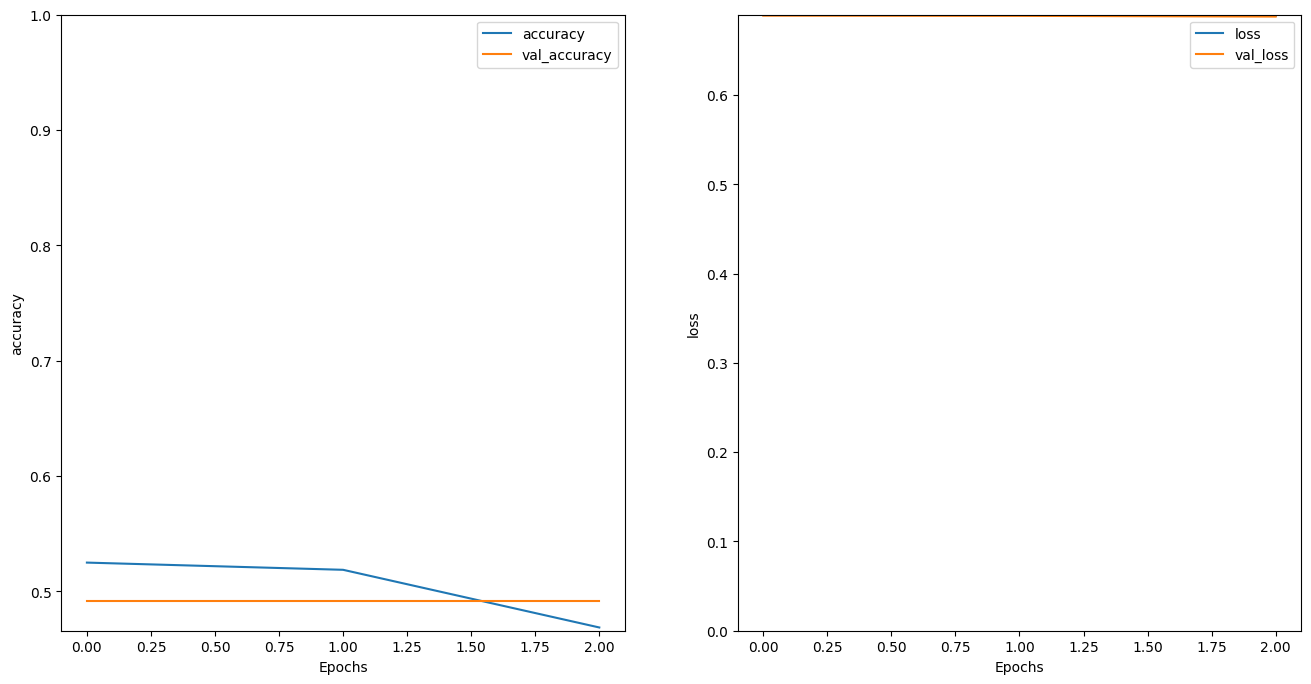

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 44ms/step
[-0.09519832]


## Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset,
    validation_steps=30,
    steps_per_epoch=10
)

Epoch 1/3
10/10 [==============================] - 85s 9s/step - loss: 0.6927 - accuracy: 0.4875 - val_loss: 0.6929 - val_accuracy: 0.4917
Epoch 2/3
10/10 [==============================] - 74s 8s/step - loss: 0.6927 - accuracy: 0.4875 - val_loss: 0.6928 - val_accuracy: 0.4917
Epoch 3/3
10/10 [==============================] - 69s 7s/step - loss: 0.6920 - accuracy: 0.4500 - val_loss: 0.6927 - val_accuracy: 0.4917


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 295s 756ms/step - loss: 0.6928 - accuracy: 0.5000
Test Loss: 0.6927697062492371
Test Accuracy: 0.5


In [ ]:
# predict on a sample text without padding.

sample_text = (
'The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 59s 59s/step
[[0.01553189]]


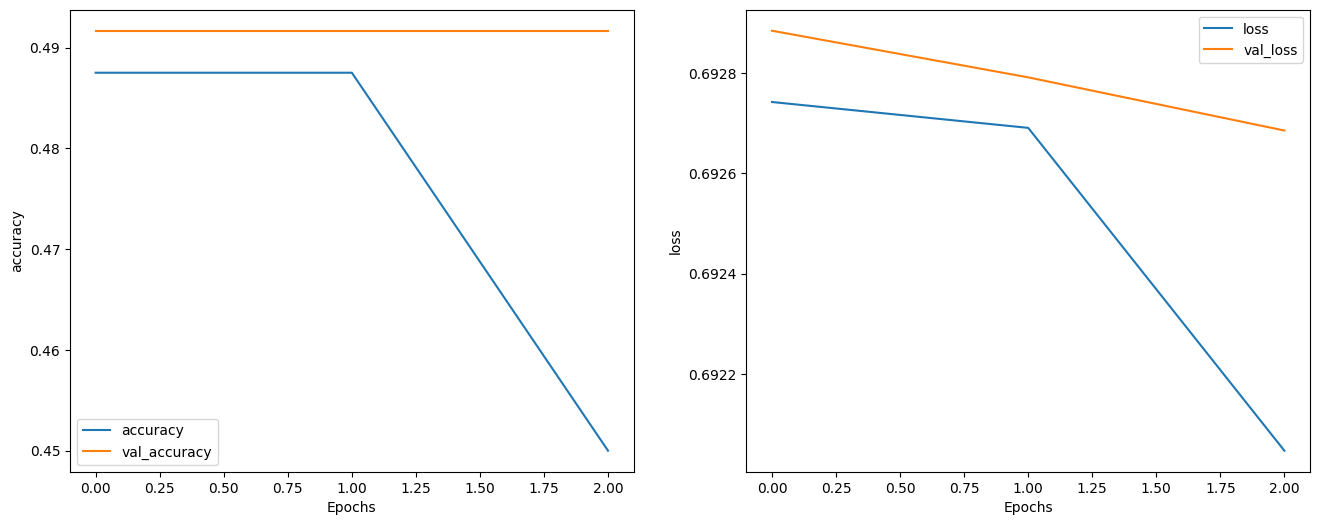

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')